# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [3]:
from sklearn.metrics import average_precision_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [4]:
# Подберём гиперпараметр регуляризации C с помощью поиска по сетке с использованием кросс-валидации:
consts = np.logspace(-3, 2, 30)
# searcher = GridSearchCV(
#     LinearSVC(),
#     [{"C": consts}],
#     scoring=make_scorer(average_precision_score, needs_threshold=True),
#     cv=15
# )
# searcher.fit(X_train, y_train)
# 
# best_C = searcher.best_params_["C"]
# print("Best C = %.4f" % best_C)
# 
# plt.plot(consts, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
# plt.xlabel("const")
# plt.ylabel("mean AUC-PR score")
# plt.title("Support Vector Classificator")
best_C = 0.3857

In [5]:
# используем функцию make_score, чтобы предобработать предсказания обученной модели перед подсчётом скора (преобразовать бинарные выходы в расстояние до разделяющей прямой)

In [6]:
model = LinearSVC(C=best_C, max_iter=10000)
model.fit(X_train, y_train)
print(average_precision_score(y_test, model.decision_function(X_test)))

model_default = LinearSVC()
model_default.fit(X_train, y_train)
print(average_precision_score(y_test, model_default.decision_function(X_test)))

C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.829949542315729


C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


0.8299563380616252


C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [7]:
# скор с наилучшей константой слабо отличим от скора с константой по умолчанию, при этом оба значения не превосходят 0.85
# чтобы найти причину этого, рассмотрим проекцию выборки на плоскость нексольких пар признаков:

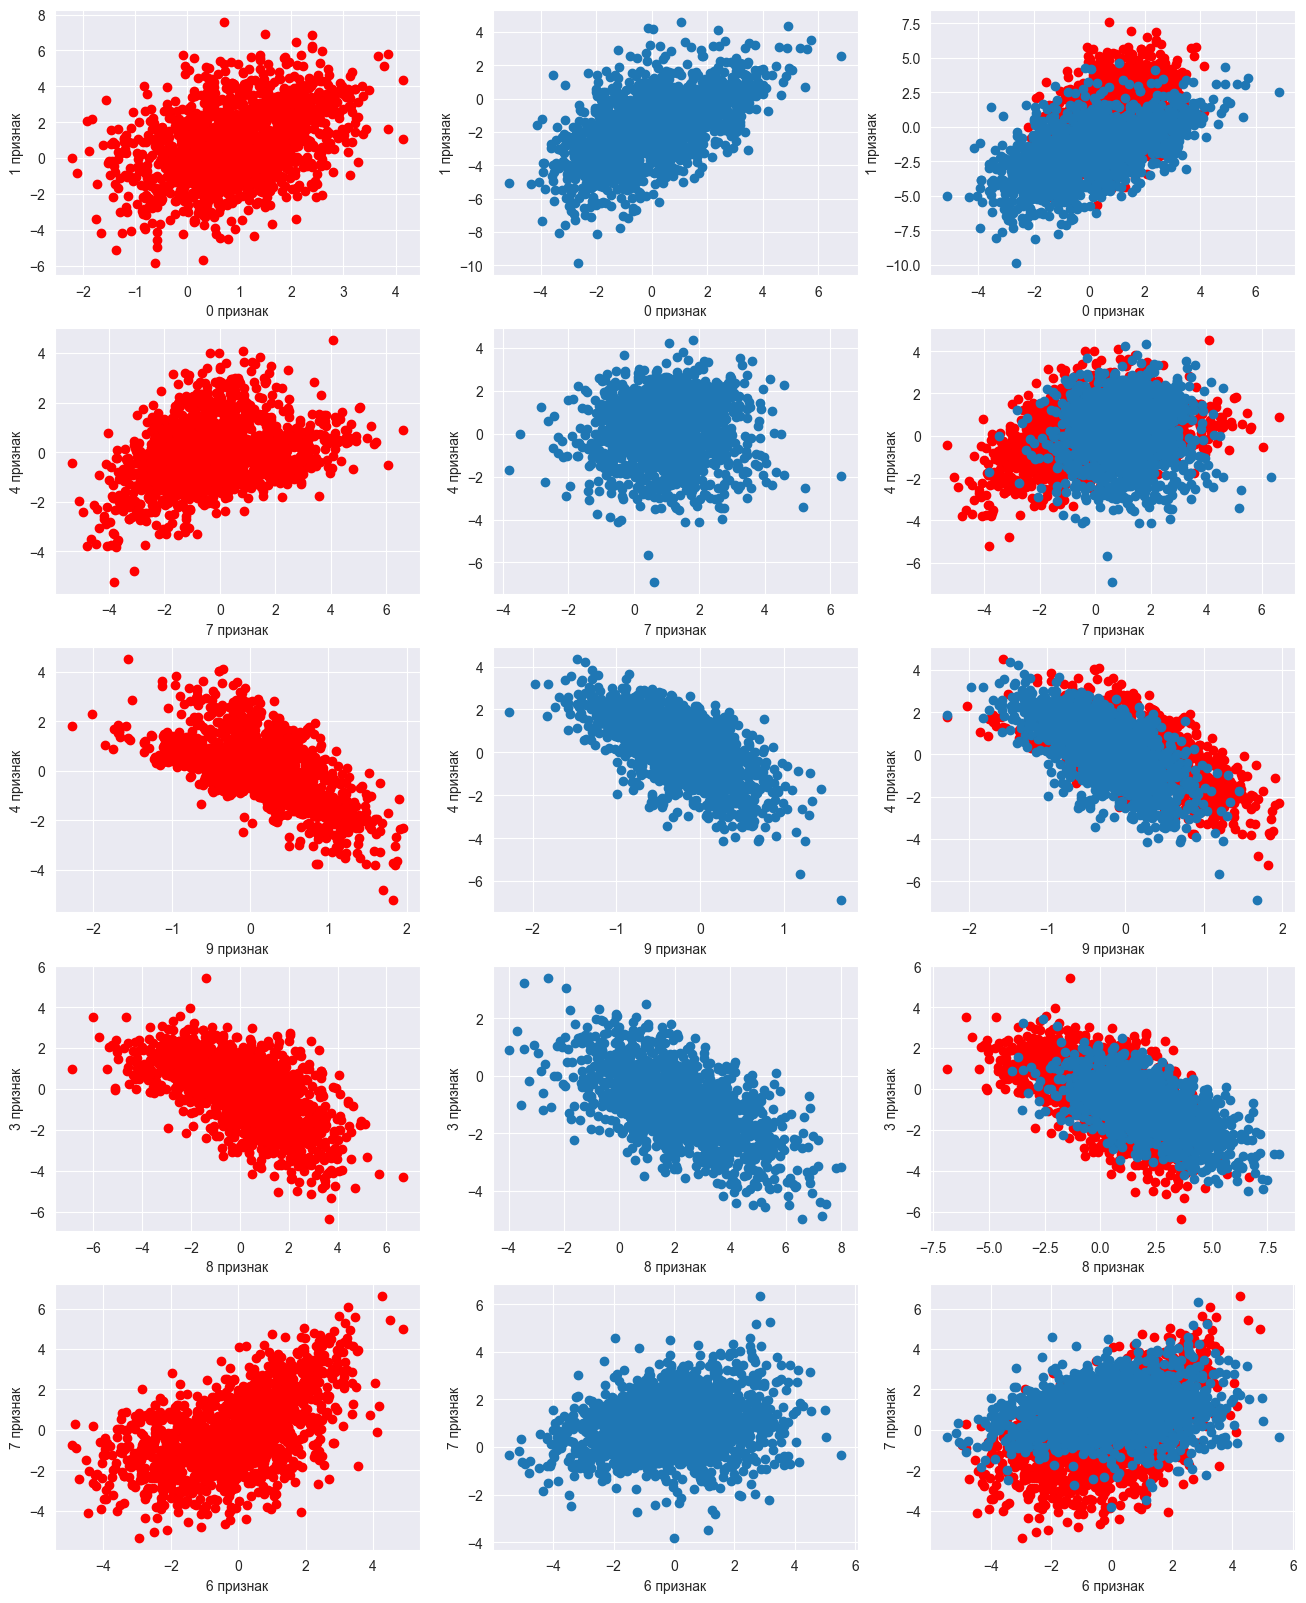

In [8]:
X1 = X_test[y_test == 1]
X0 = X_test[y_test == 0]

samples = 5
fig, axs = plt.subplots(figsize=(16, 20), ncols=3, nrows=samples)
for i, (f, s) in enumerate(np.array([[i, j] for i in range(10) for j in range(10) if j != i])
                           [np.random.choice(np.arange(90), samples, replace=False)]):
    axs[i, 0].scatter(X1[:, f], X1[:, s], c='red')
    axs[i, 1].scatter(X0[:, f], X0[:, s])
    axs[i, 0].set_xlabel(f"{f} признак")
    axs[i, 0].set_ylabel(f"{s} признак")
    axs[i, 1].set_xlabel(f"{f} признак")
    axs[i, 1].set_ylabel(f"{s} признак")

    axs[i, 2].scatter(X1[:, f], X1[:, s], c='red')
    axs[i, 2].scatter(X0[:, f], X0[:, s])
    axs[i, 2].set_xlabel(f"{f} признак")
    axs[i, 2].set_ylabel(f"{s} признак")

In [9]:
# получается объекты с равными или почти равными значениями сумм взвешенных признаков могут принадлежать как к положительному, так и к отрицательному классу, значит не стоит ожидать высокого скора

На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

In [10]:
# случайный классификатор
def y_random(X):
    # np.random.seed(1)
    return np.random.choice([0, 1], size=len(X), p=[0.5, 0.5])

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

def plot_auc(y_true, y_pred, y_rand, curve_type):
    if curve_type == 'roc':
        model_auc = roc_curve(y_true, y_pred)[:2]
        score = roc_auc_score(y_true, y_pred)
        # random_auc = roc_curve(y_true, y_rand)[:2]
        RocCurveDisplay.from_predictions(y_true, y_rand, c='lightblue', linestyle='--',
                                         label="Случайный классификатор %.5f" % roc_auc_score(y_true, y_rand))
        plt.title("AUC ROC", fontsize=15)
        plt.xlabel("FPR", fontsize=12)
        plt.ylabel("TPR", fontsize=12)
    elif curve_type == 'pr':
        model_auc = precision_recall_curve(y_true, y_pred)[:2][::-1]
        score = average_precision_score(y_true, y_pred)
        # random_auc = precision_recall_curve(y_true, y_rand)[:2][::-1]
        PrecisionRecallDisplay.from_predictions(y_true, y_rand, c='lightblue', linestyle='--',
                                                label="Случайный классификатор %.5f" % average_precision_score(y_true, y_rand))
        plt.title("AUC PR", fontsize=15)
        plt.xlabel("recall", fontsize=12)
        plt.ylabel("precision", fontsize=12)
    plt.plot(*model_auc, c='orange', label="Обученная модель %.5f" % score)
    # plt.plot(*random_auc, c='lightblue', linestyle='--', label="Случайный классификатор")
    plt.legend()
    plt.show()

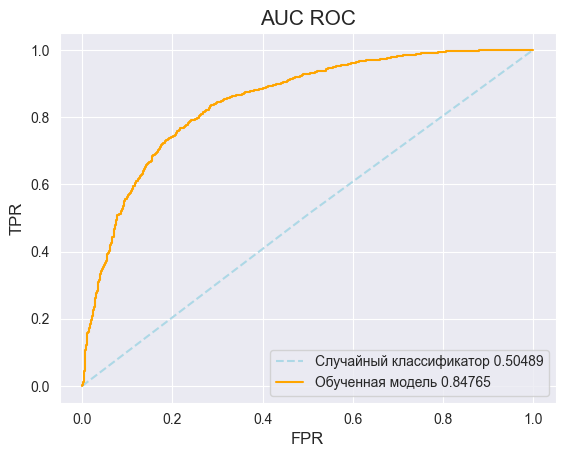

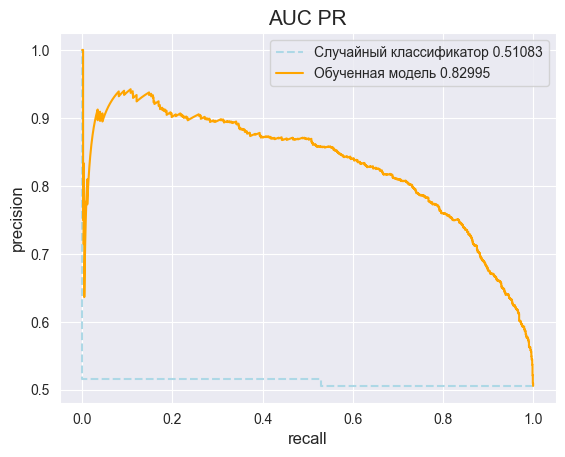

In [12]:
plot_auc(y_test, model.decision_function(X_test), y_random(X_test), 'roc')
# print("SVC AUC ROC score = %.5f   " % roc_auc_score(y_test, model.decision_function(X_test)),
#       "random classifier AUC ROC = %.5f" % roc_auc_score(y_test, y_random(X_test)))
plot_auc(y_test, model.decision_function(X_test), y_random(X_test), 'pr')
# print("SVC AUC PR score = %.5f    " % average_precision_score(y_test, model.decision_function(X_test)),
#       "random classifier AUC PR = %.5f" % average_precision_score(y_test, y_random(X_test)))

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [13]:
from sklearn.linear_model import LogisticRegression
# searcher = GridSearchCV(
#     LogisticRegression(),
#     [{"C": consts}],
#     scoring=make_scorer(average_precision_score, needs_threshold=True),
#     cv=15
# )
# searcher.fit(X_train, y_train)
# 
# best_C = searcher.best_params_["C"]
# print("LR Best C = %.4f" % best_C)
# 
# plt.plot(consts, searcher.cv_results_["mean_test_score"])
# plt.xscale("log")
# plt.xlabel("const")
# plt.ylabel("mean AUC-PR score")
# plt.title("Logistic Regression")
best_C = 0.001

In [14]:
model = LogisticRegression(C=best_C, max_iter=10000)
model.fit(X_train, y_train);

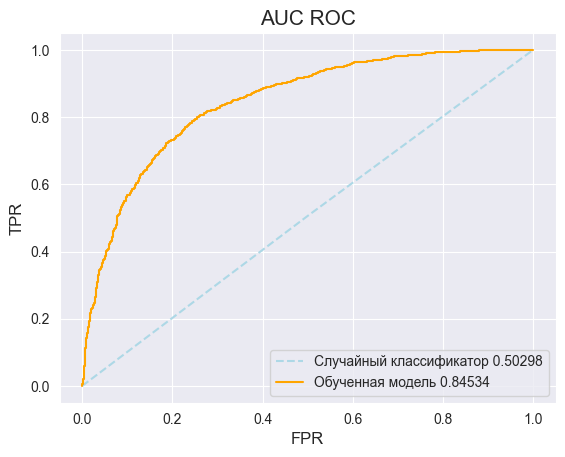

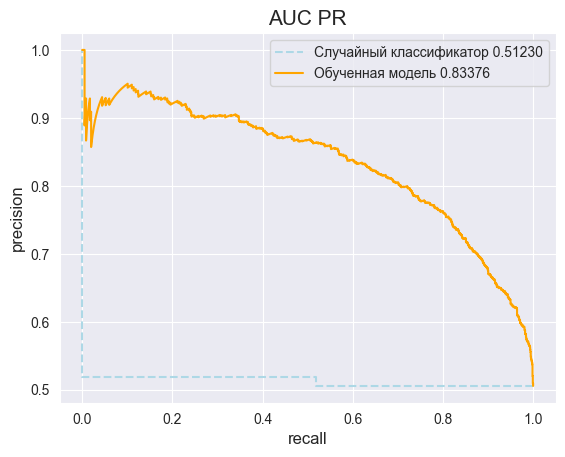

LR AUC ROC score = 0.84534    random classifier AUC ROC = 0.49327
LR AUC PR score = 0.83376     random classifier AUC ROC = 0.50703


In [15]:
plot_auc(y_test, model.decision_function(X_test), y_random(X_test), 'roc')
plot_auc(y_test, model.decision_function(X_test), y_random(X_test), 'pr')

print("LR AUC ROC score = %.5f   " % roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
      "random classifier AUC ROC = %.5f" % roc_auc_score(y_test, y_random(X_test)))
print("LR AUC PR score = %.5f    " % average_precision_score(y_test, model.predict_proba(X_test)[:, 1]),
      "random classifier AUC ROC = %.5f" % average_precision_score(y_test, y_random(X_test)))

In [16]:
# графики мало чем отличаются. Возможно это происходит из-за "искусственности" выборки

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [17]:
X, y = make_classification(
    n_samples=10000,
    n_features=2,
    n_redundant=0
    ,random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [18]:
from sklearn.svm import SVC
model = SVC(kernel='linear', max_iter=100000)
model.fit(X_train, y_train)
roc_auc_score(y_test, model.decision_function(X_test))

0.9456302800375469

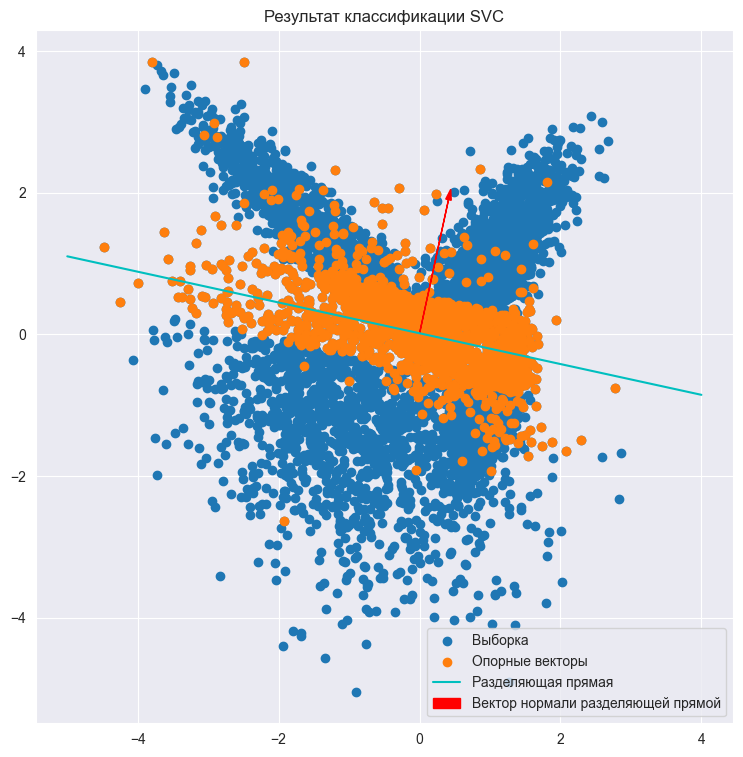

In [19]:
w1, w2 = model.coef_[0]
w0 = model.intercept_[0]
plt.figure(figsize=(9, 9))
plt.scatter(X_train[:, 0], X_train[:, 1], label='Выборка')
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], label='Опорные векторы')
plt.plot([-5, 4],
         [-(-5 * w1 + w0) / w2, -(4 * w1 + w0) / w2],
         c='c',
         label='Разделяющая прямая')
plt.arrow(x=0, dx=w1,
          y=-w0 / w2, dy=w2,
          color='r',
          head_width=0.08,
          head_length=0.15,
          label='Вектор нормали разделяющей прямой')
plt.title("Результат классификации SVC")
plt.legend();

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [20]:
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train);

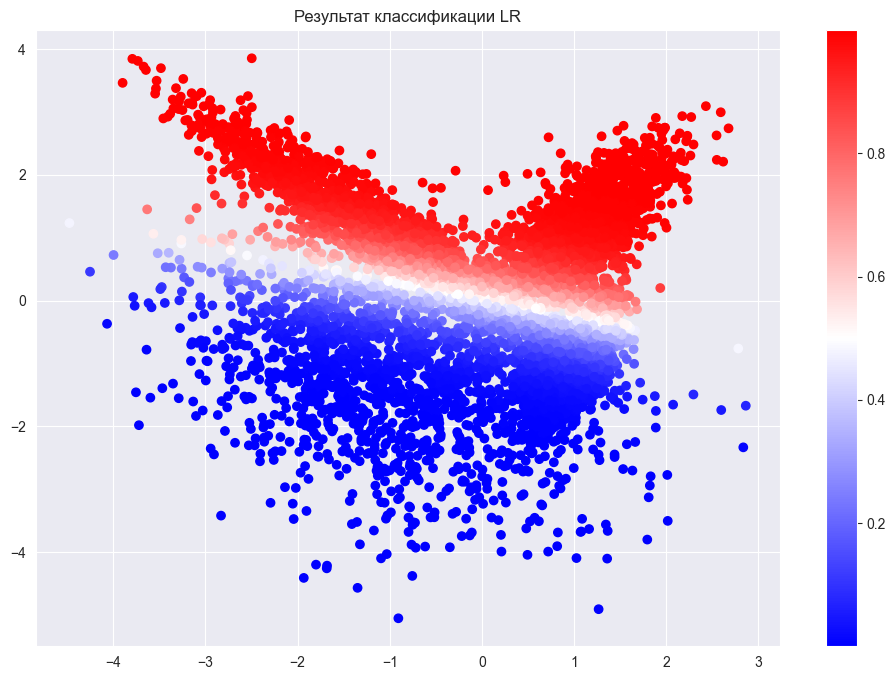

In [21]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=model.predict_proba(X_train)[:, 1], cmap='bwr')
plt.title("Результат классификации LR")
plt.colorbar();

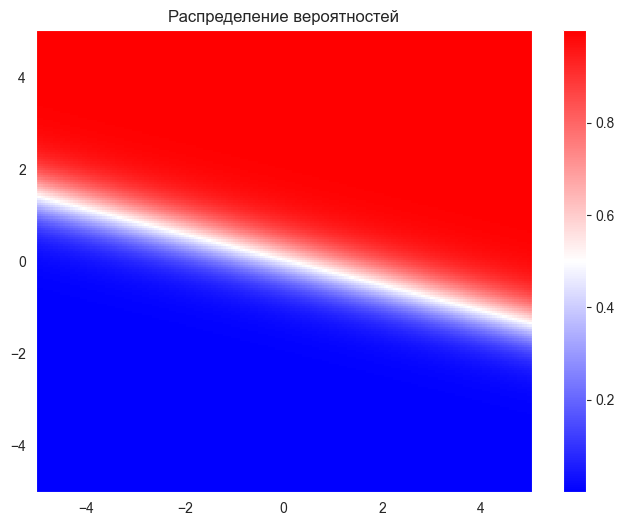

In [22]:
# генерируем сетку
da, db = 0.05, 0.05
b, a = np.mgrid[-5:5+db:db, -5:5+da:da]

# растягиваем "оси" в одномерный вектор и совмещаем их по длинне
a = a.reshape(40401)
b = b.reshape(40401)

c = np.vstack((a, b)).T
# из обученной модели получаем веорятность положительного класса для каждой точки сетки
# затем обратно изменяем форму массива c, чтобы его значения были образом отображения декартова произведения осей функцией предсказания модели
c = model.predict_proba(c)[:, 1].reshape((201, 201))

plt.figure(figsize=(8, 6))
plt.pcolormesh(a.reshape((201, 201)), b.reshape((201, 201)), c, cmap='bwr')
plt.title("Распределение вероятностей")
plt.colorbar()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [23]:
def plot_calibration_curve(y_test, preds, model_name='модель'):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], c='green', linestyle='--', label='Идеальная модель')
    plt.plot(bin_middle_points, bin_real_ratios, c='orange', label=model_name)
    plt.xlabel('предсказанная вероятность')
    plt.ylabel('доля объектов положительного класса')
    plt.legend()
    plt.xticks(np.linspace(0, 1, n_bins + 1))
    plt.yticks(np.linspace(0, 1, n_bins + 1))
    plt.title("Калибровочная кривая")
    plt.ylim([-0.05, 1.05])

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [24]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

SVC_model = LinearSVC(C=1.2690, max_iter=100000)
SVC_model.fit(X_train, y_train)
SVC_pred = SVC_model.decision_function(X_test)
SVC_pred = (SVC_pred - SVC_pred.min()) / (SVC_pred.max() - SVC_pred.min())

LR_model = LogisticRegression(C=0.001, max_iter=100000)
LR_model.fit(X_train, y_train)
LR_pred = LR_model.predict_proba(X_test)[:, 1];

C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


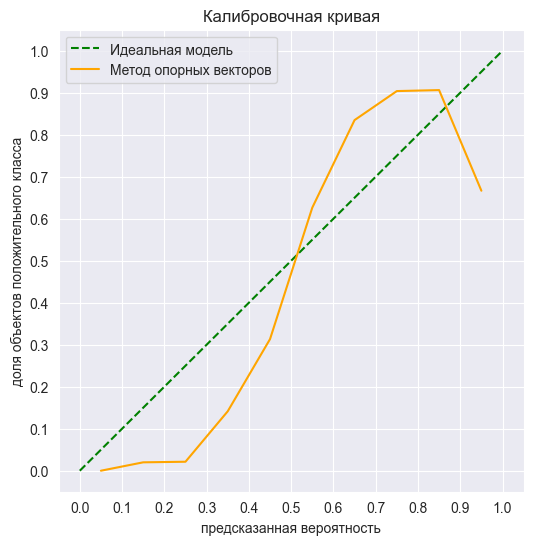

In [25]:
plot_calibration_curve(y_test, SVC_pred, 'Метод опорных векторов');

In [26]:
# видно, что модель не откалибрована
# такое может происходить из-за того, что SVC много внимания уделяет объектам, которые находятся на границе классов, в ущерб более однозначно определяемым точкам

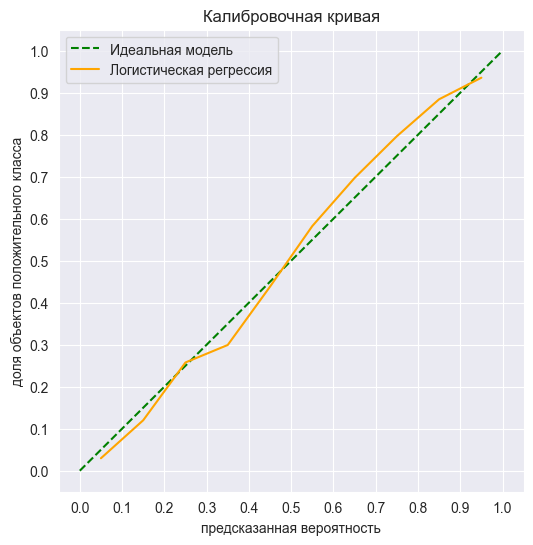

In [27]:
plot_calibration_curve(y_test, LR_pred, "Логистическая регрессия");

In [28]:
# модель хорошо откалибрована

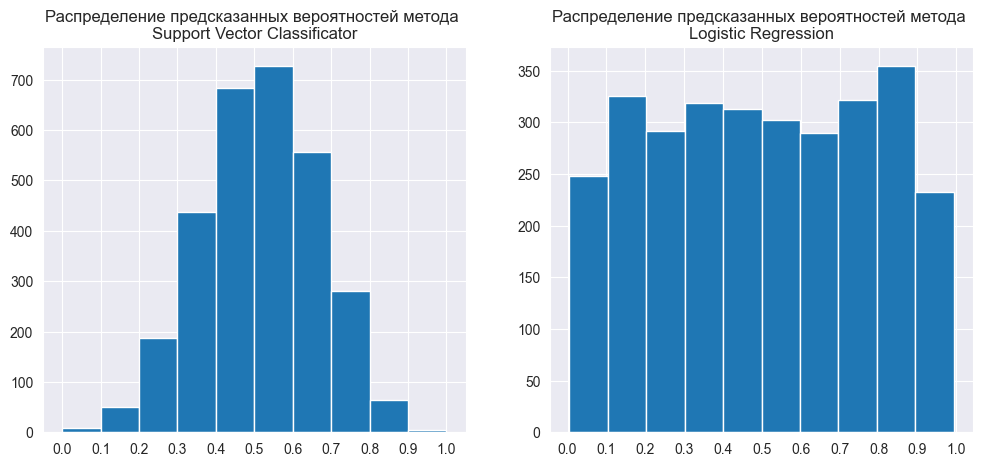

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

axs[0].set_title("Распределение предсказанных вероятностей метода \nSupport Vector Classificator")
axs[0].hist(SVC_pred)
axs[0].set_xticks(np.linspace(0, 1, 11))

axs[1].set_title("Распределение предсказанных вероятностей метода \nLogistic Regression")
axs[1].hist(LR_pred)
axs[1].set_xticks(np.linspace(0, 1, 11));

In [30]:
# график распределения предсказаний логистической регрессии близок к графику плотности равномерного распределения,в отличие от графика распределения предсказаний метода опорных векторов, который большей части объектов дал вероятности близкие к 0.5.
# график распределения предсказаний SVC подтверждает мысль о том, что данный метод ставит главной задачей "разобраться" с пограничными объектами

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [31]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_SVC = CalibratedClassifierCV(SVC_model, cv=5).fit(X_train, y_train)
calibrated_SVC_pred = calibrated_SVC.predict_proba(X_test)[:, 1];

C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

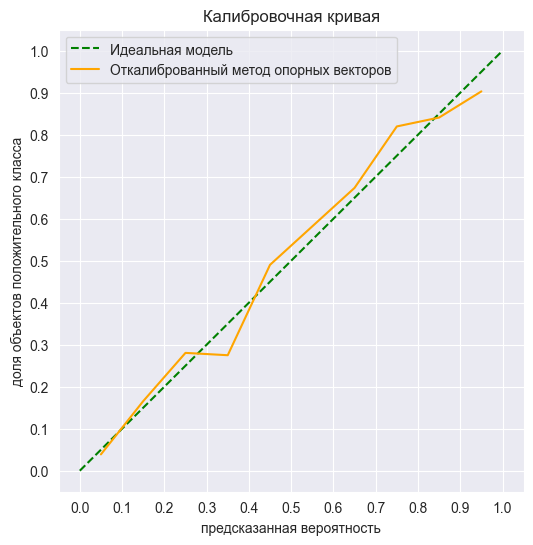

In [32]:
plot_calibration_curve(y_test, calibrated_SVC_pred, 'Откалиброванный метод опорных векторов');

In [33]:
# калибровочная кривая стала близка к калибровочной кривой идеальной модели, следовательно можно говорить о том, что полученная модель хорошо предсказывает вероятности

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [34]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [35]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [36]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [37]:
# изучив признаки можно сказать, что можно добавить признак 'pdays == 999'
# так как нельзя ассоциировать то что человек ни разу не обращался в компанию с вещественным числом 999

__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [38]:
# стобец duration не несёт пользы для обучения, так как звонки клиентам не будут совершаться
df.drop('duration', axis=1, inplace=True)

In [39]:
# from sklearn.preprocessing import LabelEncoder

y = df.y
# label_encoding = LabelEncoder()
# y = label_encoding.fit_transform(y)
# print(label_encoding.transform(['yes', 'no']))
y = (df.y == 'yes')
X = df.drop('y', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=777, stratify=y)
# используем стратификацию, чтобы сохранить распределения на трейне и тесте

In [40]:
print(f'Количество исходных признаков = {X.shape[1]}')

Количество исходных признаков = 19


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


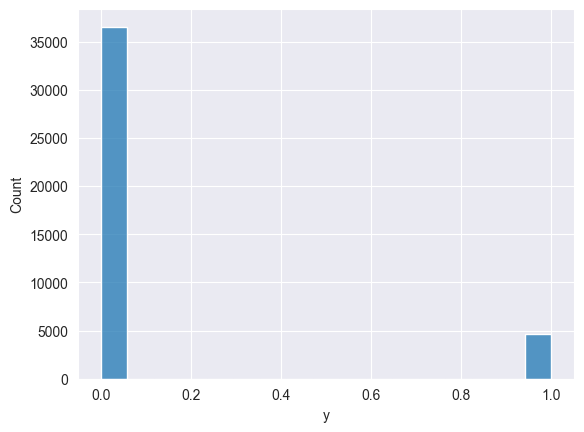

In [41]:
# посмотрим насоотношение классов целевой переменной:
sns.histplot(y);

In [42]:
# количество объектов отрицательного класса примерно в 9 раз больше объектов положительного класса

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: из-за соотношения классов в распределении целевой переменной, модель может отнести много отрицательных объектов к положительному классу и это не сильно отразится на качестве метрики AUC-ROC

In [43]:
categorical = np.array(X_train.columns[X_train.dtypes == 'object'])
numerical = np.array(X_train.columns[X_train.dtypes != 'object'])

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

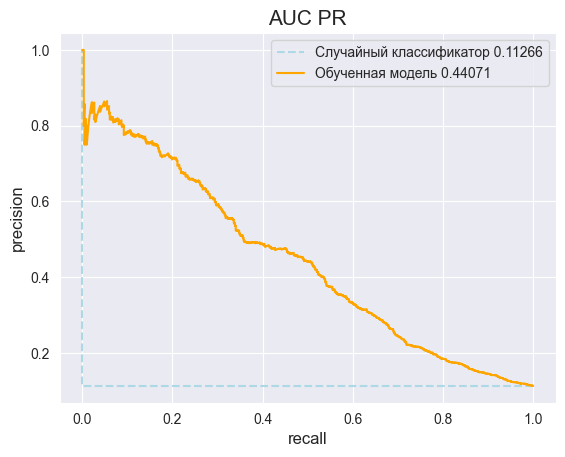

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

column_transformer = ColumnTransformer([
    ('oe', OrdinalEncoder(), categorical)],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('oe', column_transformer),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr')

__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



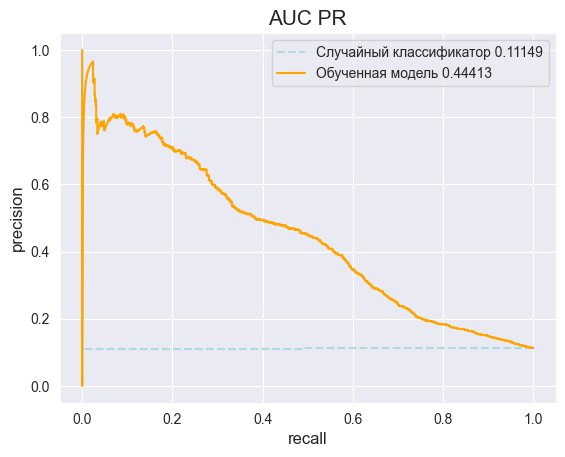

In [46]:
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical)],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr');

In [47]:
# качество модели с OHE выше качества модели с OE

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


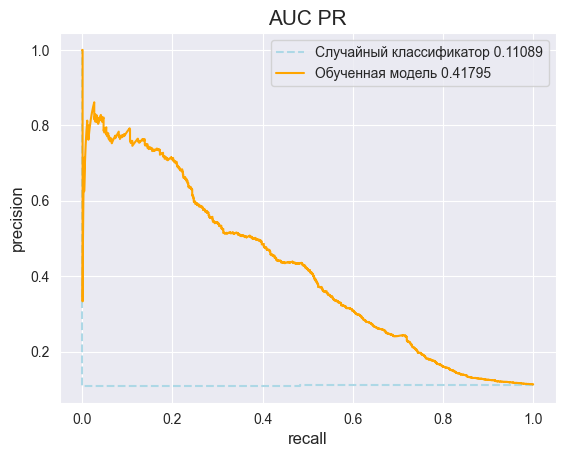

In [48]:
from sklearn.preprocessing import TargetEncoder

column_transformer = ColumnTransformer([
    ('mean-target', TargetEncoder(), categorical)],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('mean-target', column_transformer),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr');

In [49]:
# при кодировании с использованием счётчиков качество модели стало хуже, чем с проядковым кодированием, но время обучения заметно уменьшилось

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [50]:
#your code here

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [51]:
#your code here

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [52]:
#your code here

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [53]:
len(df.age.unique())

78

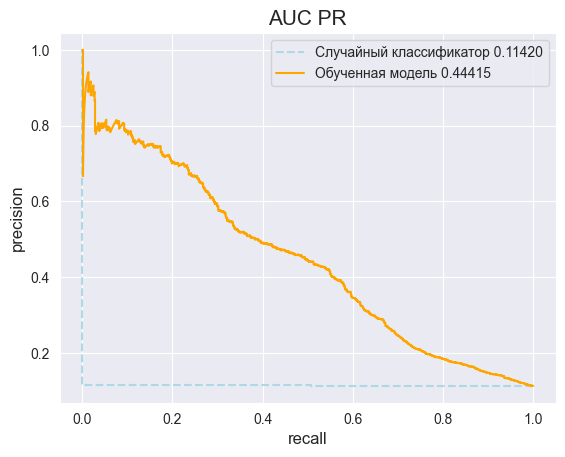

In [54]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('age mean-target', TargetEncoder(), ['age'])],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr');

In [55]:
# если считать возраст числовым признаком, то качество модели немного хуже, чем если считать возраст категориальным и кодировать через счётчики

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [56]:
class MonthEncoding(BaseEstimator, TransformerMixin):
    month_number = {'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5,
                    'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11}
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.replace(self.month_number)

class DayEncoding(BaseEstimator, TransformerMixin):
    week_day_number = {'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri': 4}
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.replace(self.week_day_number)

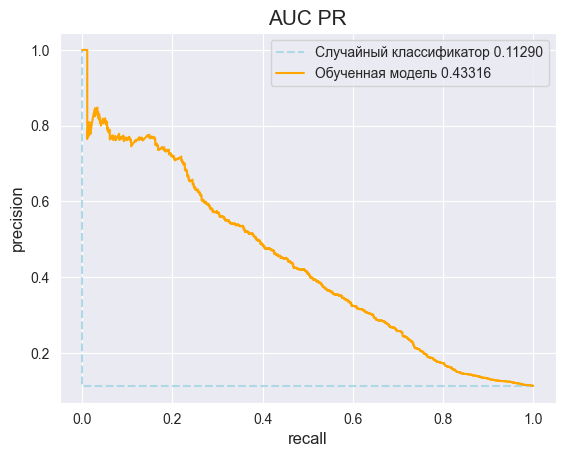

In [57]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), np.delete(categorical, [7, 8])),
    ('month', MonthEncoding(), np.array(['month'])),
    ('day', DayEncoding(), ['day_of_week'])],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr');

In [58]:
# качество стало немного хуже

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 
Плюсы: счётчики не увеличивают количество признаков и заметно ускоряют процесс обучения
Минусы: счётчики больше склонны к переобучению и имеют качество хуже на тесте, чем модель с OHE

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [59]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [60]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical)],
    remainder='passthrough')
column_transformer.fit_transform(X_train, y_train).shape[1]

62

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

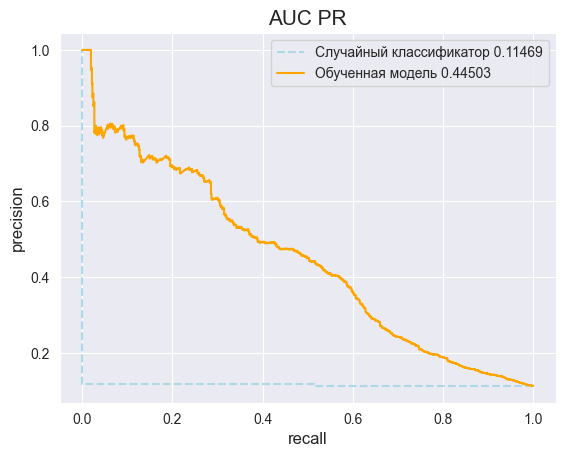

In [61]:
pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr')
score = average_precision_score(y_test, y_pred)

### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [62]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=pipeline.steps[-1][-1], threshold=-np.inf, prefit=True, max_features=40)

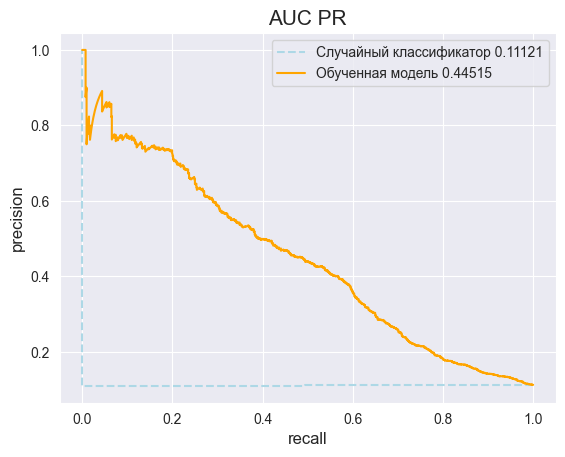

In [63]:
pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('feature selection', selector),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr')

In [64]:
# качество увеличилось, но незначительно

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

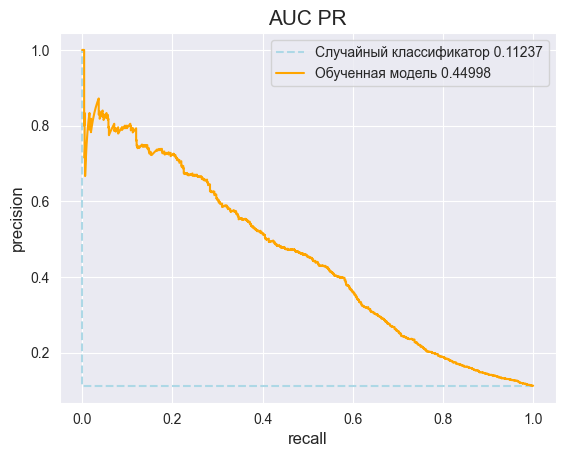

In [65]:
from sklearn.preprocessing import MinMaxScaler

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('minmax scaler', MinMaxScaler(), numerical)],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('logistic regression', LogisticRegression(max_iter=100000))
])
model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr')
selector = SelectFromModel(estimator=pipeline.steps[-1][-1], threshold=-np.inf, prefit=True, max_features=40)

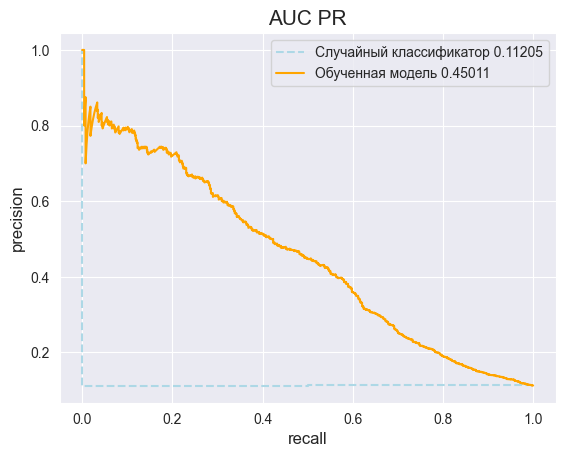

In [66]:
pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('feature selection', selector),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr')

In [67]:
# качество стало выше

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [68]:
#your code here

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



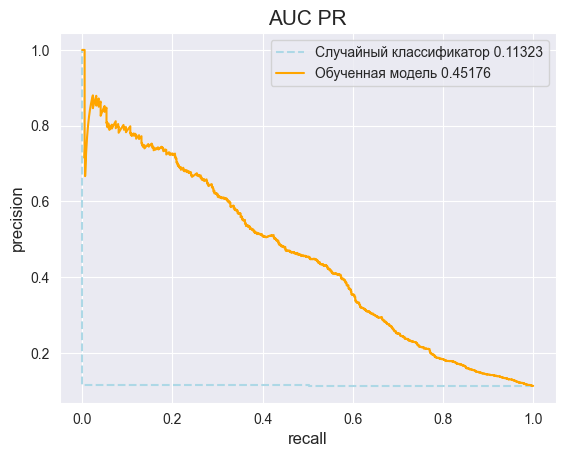

In [69]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=40)
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('minmax scaler', MinMaxScaler(), numerical)],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('feature selection', selector),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr')

In [70]:
# отбор признаков по весам оказался хуже

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

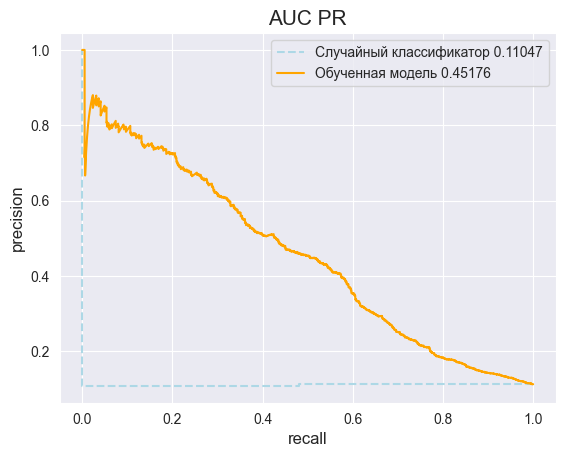

In [71]:
from sklearn.feature_selection import SequentialFeatureSelector

# selector = SequentialFeatureSelector(estimator=LogisticRegression(max_iter=10000),
#                                      n_features_to_select=40,
#                                      direction='backward',
#                                      scoring='average_precision')
# column_transformer = ColumnTransformer([
#     ('ohe', OneHotEncoder(), categorical),
#     ('minmax scaler', MinMaxScaler(), numerical)],
#     remainder='passthrough')
# 
# backward_pipeline = Pipeline(steps=[
#     ('transformations', column_transformer),
#     ('feature selection', selector),
#     ('logistic regression', LogisticRegression(max_iter=100000))
# ])
# 
# model = backward_pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr')

In [72]:
# backward_pipeline.steps[1][1].get_support()

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

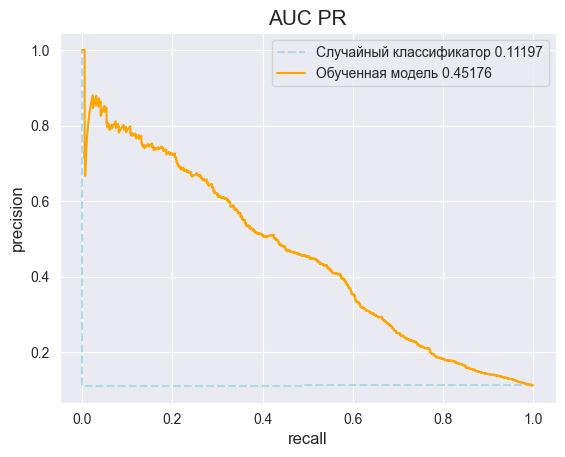

In [73]:
# selector = SequentialFeatureSelector(estimator=LogisticRegression(max_iter=10000),
#                                      n_features_to_select=40,
#                                      direction='forward',
#                                      scoring='average_precision')
# 
# forward_pipeline = Pipeline(steps=[
#     ('transformations', column_transformer),
#     ('feature selection', selector),
#     ('logistic regression', LogisticRegression(max_iter=100000))
# ])

# model = forward_pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
plot_auc(y_test, y_pred, y_random(X_test), 'pr')

In [74]:
# forward_pipeline.steps[1][1].get_support()

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [75]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [76]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('minmax scaler', MinMaxScaler(), numerical)],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('logistic regression', LogisticRegression(max_iter=100000))
])

cross_validation = cross_validate(pipeline, X, y, scoring='average_precision', cv=cv, return_estimator=True)
cross_validation

{'fit_time': array([0.80978608, 0.73219943, 0.89405775, 0.64037776, 0.62852645]),
 'score_time': array([0.01562476, 0.03125167, 0.03154516, 0.01564431, 0.0312798 ]),
 'estimator': [Pipeline(steps=[('transformations',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('ohe', OneHotEncoder(),
                                                    array(['job', 'marital', 'education', 'default', 'housing', 'loan',
         'contact', 'month', 'day_of_week', 'poutcome'], dtype=object)),
                                                   ('minmax scaler',
                                                    MinMaxScaler(),
                                                    array(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
         'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
        dtype=object))])),
                  ('logistic regression', LogisticRegression(max_iter=100000))]),
  Pipeline(steps=[

In [77]:
fitted_estimators = cross_validation['estimator']
fitted_estimators

[Pipeline(steps=[('transformations',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('ohe', OneHotEncoder(),
                                                   array(['job', 'marital', 'education', 'default', 'housing', 'loan',
        'contact', 'month', 'day_of_week', 'poutcome'], dtype=object)),
                                                  ('minmax scaler',
                                                   MinMaxScaler(),
                                                   array(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
       dtype=object))])),
                 ('logistic regression', LogisticRegression(max_iter=100000))]),
 Pipeline(steps=[('transformations',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('ohe', OneHotEncoder(),
                                   

In [78]:
revenue = [0] * 5
salary_expenses = [0] * 5
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    y_pred = fitted_estimators[i].predict(X.loc[test_index])
    mask = np.logical_and(y_pred == y.loc[test_index], y.loc[test_index] == 1)
    revenue[i] = 10 * np.sum(mask)
    salary_expenses[i] = np.sum(y_pred)
print('выручка по моделям: ', end='')
print(*revenue, sep=', ')
revenue_mean, revenue_std = np.mean(revenue), np.std(revenue, ddof=1)
print(f'средняя выручка: {revenue_mean},\nско выручки: {revenue_std}', end='\n\n')
print(f'расходы на зарплату по моделям: ', end='')
print(*salary_expenses, sep=', ', end='\n\n')
print('прибыль по моделям: ', end='')
print(*(np.array(revenue) - np.array(salary_expenses)), sep=', ')
print(f'срендняя прибыль: {np.mean(np.array(revenue) - np.array(salary_expenses))}')

выручка по моделям: 2170, 2170, 1740, 2230, 2210
средняя выручка: 2104.0,
ско выручки: 205.13410247932936

расходы на зарплату по моделям: 315, 331, 287, 332, 331

прибыль по моделям: 1855, 1839, 1453, 1898, 1879
срендняя прибыль: 1784.8


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [79]:
revenue = [0] * 5
salary_expenses = [0] * 5
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    y_pred = fitted_estimators[i].predict(X.loc[test_index])
    mask = np.logical_and(y_pred == y.loc[test_index], y.loc[test_index] == 1)
    revenue[i] = np.sum(np.random.uniform(0, 20, np.sum(mask)))
    salary_expenses[i] = np.sum(y_pred)
print('выручка по моделям: ', end='')
print(*revenue, sep=', ')
revenue_mean, revenue_std = np.mean(revenue), np.std(revenue, ddof=1)
print(f'средняя выручка: {revenue_mean},\nско выручки: {revenue_std}', end='\n\n')
print(f'расходы на зарплату по моделям: ', end='')
print(*salary_expenses, sep=', ', end='\n\n')
print('прибыль по моделям: ', end='')
print(*(np.array(revenue) - np.array(salary_expenses)), sep=', ')
print(f'срендняя прибыль: {np.mean(np.array(revenue) - np.array(salary_expenses))}')

выручка по моделям: 2251.172396915391, 2178.431640170698, 1566.9317421340497, 2225.1552106092363, 2144.27000336179
средняя выручка: 2073.1921986382326,
ско выручки: 286.00557345281095

расходы на зарплату по моделям: 315, 331, 287, 332, 331

прибыль по моделям: 1936.172396915391, 1847.4316401706978, 1279.9317421340497, 1893.1552106092363, 1813.2700033617898
срендняя прибыль: 1753.9921986382328


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

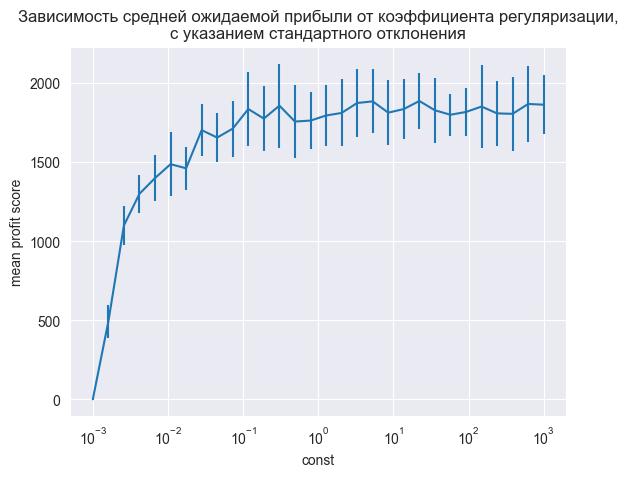

In [80]:
from sklearn.metrics import make_scorer

def calc_profit(y_true, y_pred):
    mask = np.logical_and(y_pred == y_true, y_true == 1)
    return np.sum(np.random.uniform(0, 20, np.sum(mask))) - np.sum(y_pred)
profit_scorer = make_scorer(calc_profit)

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('minmax scaler', MinMaxScaler(), numerical)],
    remainder='passthrough')

consts = np.logspace(-3, 3, 30)
profit_grid = GridSearchCV(LogisticRegression(max_iter=100_000),
                           [{'C': consts}],
                           cv=cv,
                           scoring=profit_scorer)

pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('grid search', profit_grid)
])

model = pipeline.fit(X, y)

plt.errorbar(consts, pipeline.steps[-1][-1].cv_results_["mean_test_score"], yerr=pipeline.steps[-1][-1].cv_results_["std_test_score"])
plt.xscale("log")
plt.xlabel("const")
plt.ylabel("mean profit score")
plt.title("Зависимость средней ожидаемой прибыли от коэффициента регуляризации,\nс указанием стандартного отклонения");

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [81]:
C_score = []
for i in range(10):
    pipeline.fit(X, y)
    d = pipeline.steps[-1][-1].best_params_
    d['score'] = pipeline.steps[-1][-1].best_score_
    C_score.append(d)

In [82]:
C_score

[{'C': 3.2903445623126677, 'score': 1924.4355778844729},
 {'C': 148.73521072935117, 'score': 1885.3383915979618},
 {'C': 8.531678524172806, 'score': 1864.4811380115534},
 {'C': 57.361525104486816, 'score': 1915.349325256305},
 {'C': 0.3039195382313198, 'score': 1838.8896005795505},
 {'C': 239.5026619987486, 'score': 1886.381821469115},
 {'C': 1000.0, 'score': 1882.5619855726968},
 {'C': 3.2903445623126677, 'score': 1907.7252897134126},
 {'C': 92.36708571873865, 'score': 1871.4112615212307},
 {'C': 22.122162910704503, 'score': 1871.969208163971}]

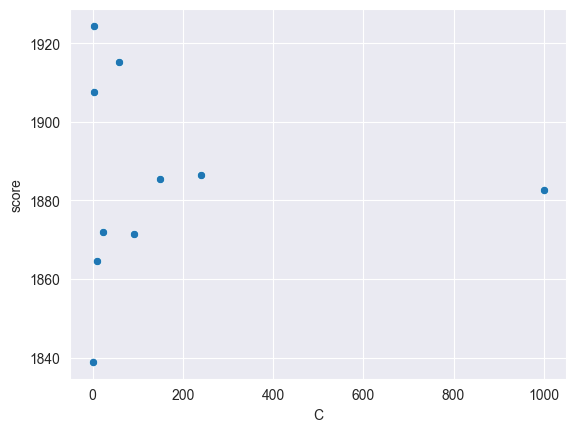

In [83]:
sns.scatterplot(data=pd.DataFrame(C_score), x="C", y='score');

In [84]:
# каждый раз находятся разные "лучшие" коэффициенты и закономерности не наблюдается, кроме той, что эти значения лежат в диапазоне от 0 до 10^3

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__
Важнее хороший recall, так как расход на звонок равен 1 доллару, а выручить хотя бы 10 долларов с клиента вероятность хотя бы 1/2, поэтому лучше сделать больше "провальных" звонков, чем не совершить какое-то количество "успешных"


Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [85]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('minmax scaler', MinMaxScaler(), numerical)],
    remainder='passthrough')

pipeline = Pipeline(steps=[
    ('transformations', column_transformer),
    ('logistic regression', LogisticRegression(max_iter=100_000))
])

model = pipeline.fit(X, y)

In [86]:
from sklearn.metrics import recall_score, precision_score

thresholds = np.arange(0, 1.01, 0.01)

results = {"threshold": [],
           "mean_recall": [],
           "std_recall": [],
           "mean_precision": [],
           "std_precision": [],
           "mean_profit": [],
           "std_profit": []}

threshold_best_profit = 0
best_profit = 0
recall_best_profit = 0
precision_best_profit = 0

for threshold in thresholds:
    recall = []
    precision = []
    profit = []
    for train_index, test_index in cv.split(X, y):
        X_train, y_train, X_test, y_test = X.loc[train_index], y.loc[train_index], X.loc[test_index], y.loc[test_index]
        model.fit(X_train, y_train)
        y_pred = np.where(model.predict_proba(X_test)[:,1] > threshold, 1, 0)
        recall.append(recall_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        profit.append(calc_profit(y_test, y_pred))
    results['threshold'].append(threshold)
    results['mean_recall'].append(np.mean(recall))
    results['std_recall'].append(np.std(recall, ddof=1))
    results['mean_precision'].append(np.mean(precision))
    results['std_precision'].append(np.std(precision, ddof=1))
    results['mean_profit'].append(np.mean(profit))
    if best_profit < results['mean_profit'][-1]:
        best_profit = results['mean_profit'][-1]
        threshold_best_profit = results['threshold'][-1]
        recall_best_profit = results['mean_recall'][-1]
        precision_best_profit = results['mean_precision'][-1]
    results['std_profit'].append(np.std(profit, ddof=1))
print('threshold_best_profit =', threshold_best_profit)
print('recall_best_profit =', recall_best_profit)
print('precision_best_profit =', precision_best_profit)
print('best_profit =', best_profit)

C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andre\PycharmProjects\pythonPro

threshold_best_profit = 0.13
recall_best_profit = 0.6114224137931035
precision_best_profit = 0.3676012980783359
best_profit = 4208.7843391878


C:\Users\andre\PycharmProjects\pythonProject2\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

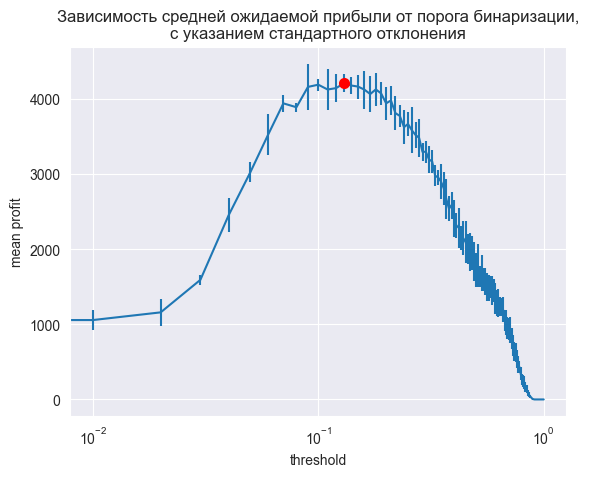

In [87]:
plt.scatter(threshold_best_profit, best_profit, marker='.', c='#ff0000', linewidths=5, zorder=2)
plt.errorbar(thresholds, results['mean_profit'], yerr=results["std_profit"], zorder=1)
plt.xscale("log")
plt.xlabel("threshold")
plt.ylabel("mean profit")
plt.title("Зависимость средней ожидаемой прибыли от порога бинаризации,\nс указанием стандартного отклонения");

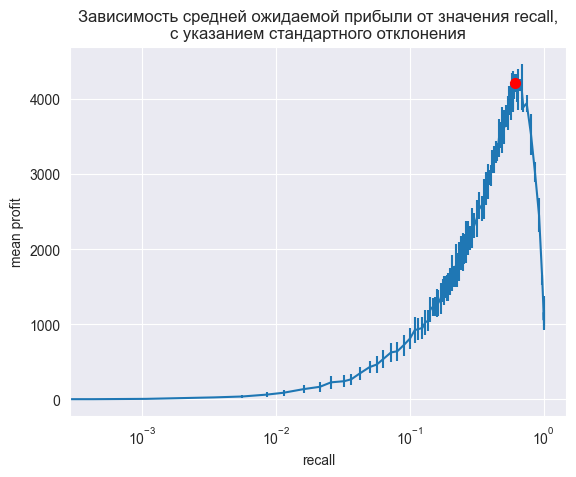

In [88]:
plt.scatter(recall_best_profit, best_profit, marker='.', c='#ff0000', linewidths=5, zorder=2)
plt.errorbar(results['mean_recall'], results['mean_profit'], yerr=results["std_profit"], zorder=1)
plt.xscale("log")
plt.xlabel("recall")
plt.ylabel("mean profit")
plt.title("Зависимость средней ожидаемой прибыли от значения recall,\nс указанием стандартного отклонения");

In [89]:
# оптимальное значение порога приблизительно равно 0.1. Возможно такое получается из-за того, что матожидание прибыли с клиента равно 10 долларам, а затраты на его обслуживания равны 1 доллару. Если предположить, что прибль с клиента - равномерно распределенная случайная величина на отрезке [0, 10], то оптимальным порогом будет число 0.2 и матожидание прибыли с клиента равно 5. Таким образом, можно утверждать, что оптимальное значение порога биаризации равно средние_расходы_на_клиента / средняя_прибыль_с_клиента. Кроме того, модель оценивает вероятности, а значит  

In [90]:
# p * (e - 1) + (1 - p) * (-1) = e * p - 1

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

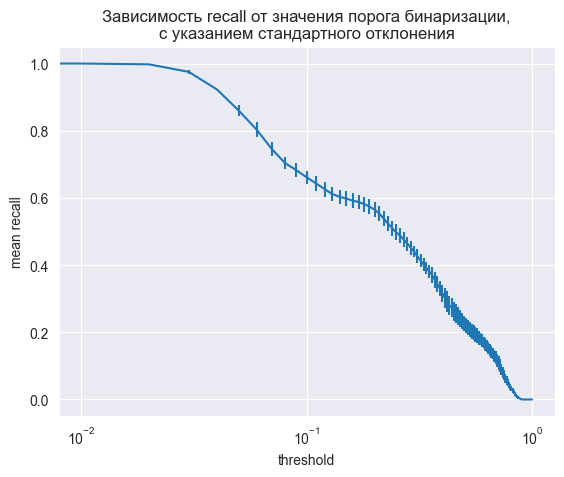

In [91]:
# plt.scatter(threshold_best_profit, recall_best_profit, marker='.', c='#ff0000', linewidths=5, zorder=2)
plt.errorbar(thresholds, results['mean_recall'], yerr=results["std_recall"], zorder=1)
plt.xscale("log")
plt.xlabel("threshold")
plt.ylabel("mean recall")
plt.title("Зависимость recall от значения порога бинаризации,\nс указанием стандартного отклонения");

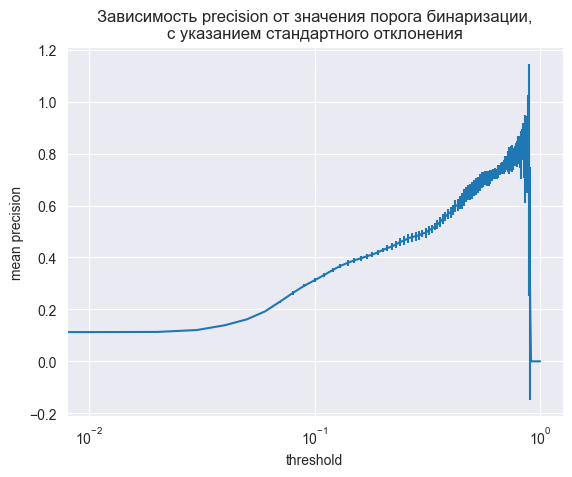

In [92]:
# plt.scatter(threshold_best_profit, recall_best_profit, marker='.', c='#ff0000', linewidths=5, zorder=2)
plt.errorbar(thresholds, results['mean_precision'], yerr=results["std_precision"], zorder=1)
plt.xscale("log")
plt.xlabel("threshold")
plt.ylabel("mean precision")
plt.title("Зависимость precision от значения порога бинаризации,\nс указанием стандартного отклонения");

Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

AUC-ROC with recall > 0.5 = 0.5506317422565786


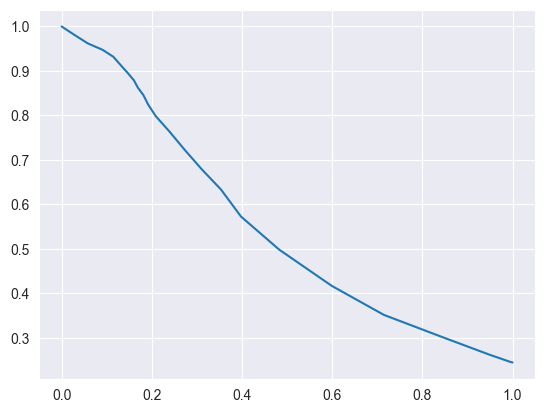

In [116]:
big_recall_mask = np.greater(results['mean_recall'], 0.5)
big_recall = np.array(results['mean_recall'])[big_recall_mask][::-1]
big_recall_precision = np.array(results['mean_precision'])[big_recall_mask][::-1]
minmaxed_recall = (big_recall - np.min(big_recall)) / (np.max(big_recall) - np.min(big_recall))
minmaxed_precision = big_recall_precision / np.max(big_recall_precision)
print("AUC-ROC with recall >= 0.5 =", np.trapz(minmaxed_precision, minmaxed_recall))
plt.plot(minmaxed_recall, minmaxed_precision);

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__